## HPA Single Cell Classification

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

## Load data.

In [ ]:
#Mount to folder in drive.
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

!mkdir /tmp/T
!gsutil -m cp /gdrive/My\ Drive/HPA/* /tmp/
!mv /tmp/T/hpa_p /tmp/train
!unzip -q /tmp/hpa.zip -d /tmp/T

Mounted at /gdrive
Copying file:///gdrive/My Drive/HPA/hpa.zip...
Copying file:///gdrive/My Drive/HPA/train.csv...
\ [2 files][  6.7 GiB/  6.7 GiB]  248.3 KiB/s                                   
Operation completed over 2 objects/6.7 GiB.                                      


In [1]:
import os
from pathlib import Path
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import cv2

from fastai import *
from fastai.vision import *
from fastai.vision.image import *
import fastai
fastai.__version__

'1.0.61'

In [ ]:
#Explore data.
df = pd.read_csv('/tmp/train.csv')
df.columns = ['Id', 'Target']
df.head()

,Id,Target
0,5c27f04c-bb99-11e8-b2b9-ac1f6b6435d0,8|5|0
1,5fb643ee-bb99-11e8-b2b9-ac1f6b6435d0,14|0
2,60b57878-bb99-11e8-b2b9-ac1f6b6435d0,6|1
3,5c1a898e-bb99-11e8-b2b9-ac1f6b6435d0,16|10
4,5b931256-bb99-11e8-b2b9-ac1f6b6435d0,14|0


/usr/local/lib/python3.6/dist-packages/fastai/core.py:302: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(a, dtype=dtype, **kwargs)


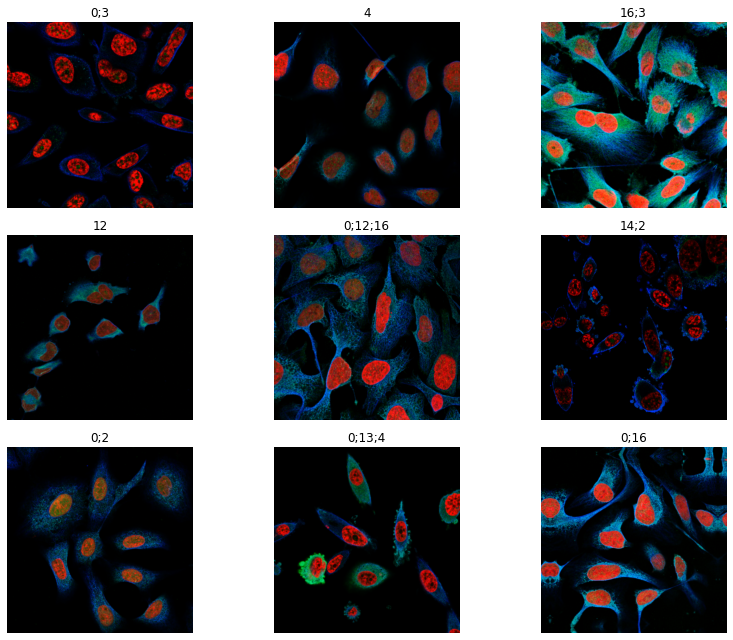

In [ ]:
#Define data generator.
np.random.seed(42)
#protein_stats = ([0.08069, 0.05258, 0.05487, 0.08282], [0.13704, 0.10145, 0.15313, 0.13814])
protein_stats = ([0.08069, 0.05258, 0.05487], [0.13704, 0.10145, 0.15313])
tfms = get_transforms(do_flip=True, flip_vert=True, max_rotate=180.0, max_lighting=0.4, p_affine=0.7, p_lighting=0.7)
src = ImageDataBunch.from_csv(path, csv_labels='train.csv', folder='train', suffix='.png', label_delim='|', bs = 64, ds_tfms=tfms)
#trn_tfms,_ = get_transforms(do_flip=True, flip_vert=True, max_rotate=30., max_zoom=1, max_lighting=0.05, max_warp=0.)
src.show_batch(rows=3, figsize=(12,9))
src = src.normalize(protein_stats)

Class number and names are from https://www.kaggle.com/c/hpa-single-cell-image-classification/data

0. Nucleoplasm
1. Nuclear membrane
2. Nucleoli
3. Nucleoli fibrillar center
4. Nuclear speckles
5. Nuclear bodies
6. Endoplasmic reticulum
7. Golgi apparatus
8. Intermediate filaments
9. Actin filaments 
10. Microtubules
11. Mitotic spindle
12. Centrosome
13. Plasma membrane
14. Mitochondria
15. Aggresome
16. Cytosol
17. Vesicles and punctate cytosolic patterns
18. Negative

##Training.

In [ ]:
# copied from https://github.com/fastai/fastai/blob/master/fastai/vision/learner.py
def _resnet_split(m): return (m[0][6],m[1])
f1_score = partial(fbeta, thresh=0.2, beta=1)
learn = cnn_learner(
    src,
    models.alexnet, # resnet34,
#    cut=-2,
#    split_on=_resnet_split,
    loss_func=F.binary_cross_entropy_with_logits,
    path=path,    
    metrics=[f1_score], 
)

epoch,train_loss,valid_loss,fbeta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


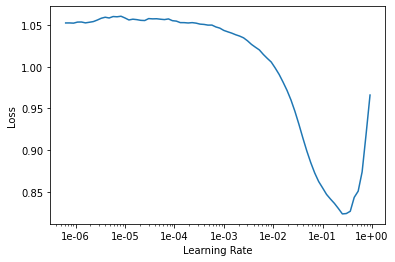

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
lr = 3e-2
learn.fit_one_cycle(3, slice(lr))
learn.save('stage-1-rn18-datablocks')

epoch,train_loss,valid_loss,fbeta,time
0,0.250415,0.228466,0.372454,09:17
1,0.231542,0.219929,0.392185,09:20
2,0.221902,0.213726,0.397292,09:22


In [ ]:
learn.unfreeze()
#learn.lr_find()
#learn.recorder.plot()
learn.fit_one_cycle(15, slice(3e-5, lr/5))
learn.save('stage-2-rn18')

epoch,train_loss,valid_loss,fbeta,time
0,0.009407,0.009304,0.201215,03:53
1,0.009063,0.009417,0.257311,03:50
2,0.008850,0.009813,0.234480,03:51
3,0.008525,0.008759,0.281220,03:55
4,0.007725,0.009753,0.210235,03:53
5,0.006729,0.009126,0.317358,03:51
6,0.005597,0.009608,0.286899,03:55
7,0.004129,0.010708,0.346725,03:55
8,0.002867,0.010764,0.334212,03:53
9,0.001852,0.011281,0.366888,03:51


KeyboardInterrupt: ignored

In [ ]:
preds,_ = learn.get_preds(DatasetType.Test)
pred_labels = [' '.join(list([str(i) for i in np.nonzero(row>0.2)[0]])) for row in np.array(preds)]
df = pd.DataFrame({'Id':test_ids,'Predicted':pred_labels})
df.to_csv(path/'protein_predictions_datablocks.csv', header=True, index=False)